# 概率

有完整的课程、专业、论文、职业、甚至院系，都致力于概率学的工作。 所以很自然地，我们在这部分的目标不是教授整个科目。 相反，我们希望教给读者基础的概率知识，使读者能够开始构建第一个深度学习模型， 以便读者可以开始自己探索它。

概率是一种灵活的语言，用于说明我们的确定程度，并且它可以有效地应用于广泛的领域中。

## 基本概率论

假设我们掷骰子，想知道看到1的几率有多大，而不是看到另一个数字。 如果骰子是公平的，那么所有六个结果
都有相同的可能发生， 因此我们可以说
发生的概率为
 
。

然而现实生活中，对于我们从工厂收到的真实骰子，我们需要检查它是否有瑕疵。 检查骰子的唯一方法是多次投掷并记录结果。 对于每个骰子，我们将观察到
中的一个值。 对于每个值，一种自然的方法是将它出现的次数除以投掷的总次数， 即此事件（event）概率的估计值。 大数定律（law of large numbers）告诉我们： 随着投掷次数的增加，这个估计值会越来越接近真实的潜在概率。 让我们用代码试一试！

首先，我们导入必要的软件包。

In [1]:
%matplotlib inline
import torch
from torch.distributions import multinomial
from d2l import torch as d2l

在统计学中，我们把从概率分布中抽取样本的过程称为抽样（sampling）。 笼统来说，可以把分布（distribution）看作对事件的概率分配， 稍后我们将给出的更正式定义。 将概率分配给一些离散选择的分布称为多项分布（multinomial distribution）。

为了抽取一个样本，即掷骰子，我们只需传入一个概率向量。 输出是另一个相同长度的向量：它在索引$i$处的值是采样结果中$i$出现的次数。

In [4]:
fair_probs = torch.ones([6]) / 6
multinomial.Multinomial(1, fair_probs).sample()

tensor([0., 1., 0., 0., 0., 0.])

In [7]:
multinomial.Multinomial(10, fair_probs).sample()

tensor([3., 1., 3., 0., 1., 2.])

In [9]:
# 将结果存储为32位浮点数以进行除法
counts = multinomial.Multinomial(1000, fair_probs).sample()
counts / 1000 # 相对频率座位估计值

tensor([0.1780, 0.1810, 0.1500, 0.1700, 0.1560, 0.1650])

因为我们是从一个公平的骰子中生成的数据，我们知道每个结果都有真实的概率$\frac{1}{6}$， 大约是$0.167$，所以上面输出的估计值看起来不错。

我们也可以看到这些概率如何随着时间的推移收敛到真实概率。 让我们进行500组实验，每组抽取10个样本。

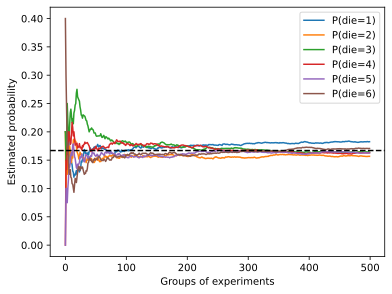

In [18]:
# 进行500组实验，每组抽取10个样本
counts = multinomial.Multinomial(10, fair_probs).sample((500,))
# 累计值求和，不降维，即每一行都会把之前的采样结果包含进来
cum_counts = counts.cumsum(dim=0)
# 计算每一个值的概率
estimates = cum_counts / cum_counts.sum(dim=1, keepdims=True)

# 设置图片大小
d2l.set_figsize((6, 4.5))
# 按列绘图，绘制每一个的结果的概率随采样次数增多的收敛情况
for i in range(6):
    d2l.plt.plot(estimates[:, i].numpy(),
                 label=("P(die=" + str(i + 1) + ")"))
# 添加值为0.167的概率基准线
d2l.plt.axhline(y=0.167, color='black', linestyle='dashed')
# 设置坐标轴标签
d2l.plt.gca().set_xlabel('Groups of experiments')
d2l.plt.gca().set_ylabel('Estimated probability')
d2l.plt.legend();

每条实线对应于骰子的6个值中的一个，并给出骰子在每组实验后出现值的估计概率。 当我们通过更多的实验获得更多的数据时，这$6$条实体曲线向真实概率收敛。

### 概率论公理

在处理骰子掷出时，我们将集合$S={1,2,3,4,5,6}$称为样本空间（sample space）或结果空间（outcome space）， 其中每个元素都是结果（outcome）。 事件（event）是一组给定样本空间的随机结果。 例如，“看到$5$”（${5}$）和“看到奇数”（${1,3,5}$
）都是掷出骰子的有效事件。 注意，如果一个随机实验的结果在$A$中，则事件$A$已经发生。 也就是说，如果投掷出$3$点，因为$3\in \{1，3，5\}$，我们可以说，“看到奇数”的事件发生了。

概率（probability）可以被认为是将集合映射到真实值的函数。 在给定的样本空间$S$中，事件$A$的概率， 表示为$P(A)$，满足以下属性：

- 对于任意事件$A$，其概率从不会是负数，即$P(A)\geq 0$；
- 整个样本空间的概率为$1$，即$P(S)=1$；
- 对于互斥（mutually exclusive）事件（对于所有$i \neq j$都有$A_i \cap A_j = \emptyset$）的任意一个可数序列$A_1,A_2,...,$，序列中任意一个事件发生的概率等于它们各自发生的概率之和，即$P(U^{\inf}_{i=1}A_i)=\sum^{\inf}_{i=1}P(A_i)$。

以上也是概率论的公理，由科尔莫戈罗夫于1933年提出。 有了这个公理系统，我们可以避免任何关于随机性的哲学争论； 相反，我们可以用数学语言严格地推理。 例如，假设事件$A_i$为整个样本空间， 且当所有$i > 1$时的$A_i=\emptyset$， 那么我们可以证明$P(\emptyset=0)$，即不可能发生事件的概率是$0$。

### 随机变量

在我们掷骰子的随机实验中，我们引入了随机变量（random variable）的概念。 随机变量几乎可以是任何数量，并且它可以在随机实验的一组可能性中取一个值。 考虑一个随机变量$X$，其值在掷骰子的样本空间$S=\{1,2,3,4,5,6\}$中。 我们可以将事件“看到一个$5$”表示为$\{X=5\}$或$X=5$， 其概率表示为$P(\{X=5\})$或$P(X=5)$。 通过$P(X=a)$，我们区分了随机变量$X$和$X$可以采取的值（例如$a$）。 然而，这可能会导致繁琐的表示。 为了简化符号，一方面，我们可以将$P(X)$表示为随机变量$X$上的分布（distribution）： 分布告诉我们$X$获得某一值的概率。 另一方面，我们可以简单用$a$表示随机变量取值的概率。 由于概率论中的事件是来自样本空间的一组结果，因此我们可以为随机变量指定值的可取范围。 例如，$P(1\leq X\leq 3)$表示事件$\{1 \leq X \leq 3\}$， 即$\{X=1,2,or,3\}$的概率。 等价地，$P(1\leq X\leq 3)$表示随机变量$X$从$\{1,2,3\}$|中取值的概率。

请注意，离散（discrete）随机变量（如骰子的每一面） 和连续（continuous）随机变量（如人的体重和身高）之间存在微妙的区别。 现实生活中，测量两个人是否具有完全相同的身高没有太大意义。 如果我们进行足够精确的测量，最终会发现这个星球上没有两个人具有完全相同的身高。 在这种情况下，询问某人的身高是否落入给定的区间，比如是否在1.79米和1.81米之间更有意义。 在这些情况下，我们将这个看到某个数值的可能性量化为密度（density）。 高度恰好为1.80米的概率为0，但密度不是0。 在任何两个不同高度之间的区间，我们都有非零的概率。 在本节的其余部分中，我们将考虑离散空间中的概率。 连续随机变量的概率可以参考深度学习数学附录中[随机变量](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/random-variables.html)的一节。

## 处理多个随机变量

很多时候，我们会考虑多个随机变量。 比如，我们可能需要对疾病和症状之间的关系进行建模。 给定一个疾病和一个症状，比如“流感”和“咳嗽”，以某个概率存在或不存在于某个患者身上。 我们需要估计这些概率以及概率之间的关系，以便我们可以运用我们的推断来实现更好的医疗服务。

再举一个更复杂的例子：图像包含数百万像素，因此有数百万个随机变量。 在许多情况下，图像会附带一个标签（label），标识图像中的对象。 我们也可以将标签视为一个随机变量。 我们甚至可以将所有元数据视为随机变量，例如位置、时间、光圈、焦距、ISO、对焦距离和相机类型。 所有这些都是联合发生的随机变量。 当我们处理多个随机变量时，会有若干个变量是我们感兴趣的。

### 联合概率

第一个被称为联合概率（joint probability）$P(A=a, B=b)$。 给定任意值$a$和$b$，联合概率可以回答：$A=a$和$B=b$同时满足的概率是多少？ 请注意，对于任何$a$和$b$的取值，$P(A=a, B=b)\leq P(A=a)$。 这点是确定的，因为要同时发生$A=a$和$B=b$，$A=a$就必须发生，$B=b$也必须发生（反之亦然）。因此，$A=a$和$B=b$同时发生的可能性不大于$A=a$或是$B=b$单独发生的可能性。

### 条件概率

联合概率的不等式带给我们一个有趣的比率：$0 \leq \frac{P(A=a,B=b)}{P(A=a)} \leq 1$。 我们称这个比率为条件概率（conditional probability）， 并用$P(B=b|A=a)$表示它：它是$B=b$的概率，前提是$A=a$已发生。

### 贝叶斯定理

使用条件概率的定义，我们可以得出统计学中最有用的方程之一： Bayes定理（Bayes’ theorem）。 根据乘法法则（multiplication rule ）可得到$P(A,B)=P(B|A)P(A)$。 根据对称性，可得到$P(A,B)=P(A|B)P(B)$。 假设$P(B)\lt 0$，求解其中一个条件变量，我们得到

$$
P(A|B)=\frac{P(B|A)P(A)}{P(B)}
$$

请注意，这里我们使用紧凑的表示法： 其中$P(A,B)$是一个联合分布（joint distribution）， $P(A|B)$是一个条件分布（conditional distribution）。 这种分布可以在给定值$A=a, B=b$上进行求值。

### 边际化

为了能进行事件概率求和，我们需要求和法则（sum rule）， 即$B$的概率相当于计算$A$的所有可能选择，并将所有选择的联合概率聚合在一起：

$$
P(B)=\sum_{A}P(A,B)
$$
 
这也称为边际化（marginalization）。 边际化结果的概率或分布称为边际概率（marginal probability） 或边际分布（marginal distribution）。

### 独立性

另一个有用属性是依赖（dependence）与独立（independence）。 如果两个随机变量$A$和$B$是独立的，意味着事件$A$的发生跟$B$事件的发生无关。 在这种情况下，统计学家通常将这一点表述为$A\perp B$。 根据贝叶斯定理，马上就能同样得到$P(A|B)=P(A)$。 在所有其他情况下，我们称$A$和$B$依赖。 比如，两次连续抛出一个骰子的事件是相互独立的。 相比之下，灯开关的位置和房间的亮度并不是（因为可能存在灯泡坏掉、电源故障，或者开关故障）。

由于$P(A|B)=\frac{P(A,B)}{P(B)}=P(A)$等价于$P(A,B)=P(A)P(B)$， 因此两个随机变量是独立的，当且仅当两个随机变量的联合分布是其各自分布的乘积。 同样地，给定另一个随机变量$C$时，两个随机变量$A$和$B$是条件独立的（conditionally independent）， 当且仅当$P(A,B|C)=P(A|C)P(B|C)$。 这个情况表示为$A\perp B|C$。

### 应用

我们实战演练一下！ 假设一个医生对患者进行艾滋病病毒（HIV）测试。 这个测试是相当准确的，如果患者健康但测试显示他患病，这个概率只有1%； 如果患者真正感染HIV，它永远不会检测不出。 我们使用$D_1$来表示诊断结果（如果阳性，则为$1$，如果阴性，则为$0$），$H$来表示感染艾滋病病毒的状态（如果阳性，则为$1$，如果阴性，则为$0$）。 在 表2.6.1中列出了这样的条件概率。

**表2.6.1 条件概率为$P(D_1|H)$**

|    条件概率     | H=1 | H=0 |
|:-----------:| :---: | :---: |
| P(D_1=1\|H) | 1 | 0.01 |
| P(D_1=0\|H) | 0 | 0.99 |

请注意，每列的加和都是1（但每行的加和不是），因为条件概率需要总和为1，就像概率一样。 让我们计算如果测试出来呈阳性，患者感染HIV的概率，即$P(H=1|D_1=1)$。 显然，这将取决于疾病有多常见，因为它会影响错误警报的数量。 假设人口总体是相当健康的，例如，$P(H=1)=0.0015$。 为了应用贝叶斯定理，我们需要运用边际化和乘法法则来确定

$$
P(D_1=1) \\
=P(D_1=1,H=0) + P(D_1=1,H=1) \\
=P(D_1=1|H=0)P(H=0)+P(D_1=1|H=1)P(H=1) \\
=0.011485
$$

因此，我们得到

$$
P(H=1|D_1=1)\\
=\frac{P(D_1=1|H=1)P(H=1)}{P(D_1=1)}\\
=0.1306
$$

换句话说，尽管使用了非常准确的测试，患者实际上患有艾滋病的几率只有13.06%。 正如我们所看到的，概率可能是违反直觉的。

患者在收到这样可怕的消息后应该怎么办？ 很可能，患者会要求医生进行另一次测试来确定病情。 第二个测试具有不同的特性，它不如第一个测试那么精确， 如 表2.6.2所示。

**表2.6.1 条件概率为$P(D_1|H)$**

|    条件概率     | H=1  | H=0  |
|:-----------:|:----:|:----:|
| P(D_1=1\|H) | 0.98 | 0.03 |
| P(D_1=0\|H) | 0.02 | 0.97 |

不幸的是，第二次测试也显示阳性。让我们通过假设条件独立性来计算出应用Bayes定理的必要概率：

$$
P(D_!=1,D_2=1|H=0)\\
=P(D_1=1|H=0)P(D_2=1|H=0)\\
=0.0003
$$

$$
P(D_1=1,D_2=1|H=1)\\
=P(D_1=1|H=1)P(D_2=1|H=1)\\
=0.98
$$

现在我们可以应用边际化和乘法规则：

$$
P(D_1=1,D_2=1)\\
=P(D_1=1,D_2=1,H=0)+P(D_1=1,D_2=1,H=1)\\
P(D_1=1,D_2=1|H=0)P(H=0)+P(D_1=1,D_2=1|H=1)P(H=1)\\
=0.00176955
$$

最后，鉴于存在两次阳性检测，患者患有艾滋病的概率为

$$
P(H=1|D_1=1,D_2=1)\\
=\frac{P(D_1=1,D_2=1|H=1)P(H=1)}{P(D_1=1,D_2=1)}\\
=0.8307
$$

也就是说，第二次测试使我们能够对患病的情况获得更高的信心。 尽管第二次检验比第一次检验的准确性要低得多，但它仍然显著提高我们的预测概率。

## 期望和方差

为了概括概率分布的关键特征，我们需要一些测量方法。 一个随机变量$X$的期望（expectation，或平均值（average））表示为

$$
E[X]=\sum_{x}xP(X=x)
$$

当函数$f(x)$的输入是从分布$P$中抽取的随机变量时，$f(x)$的期望值为

$$
E_{x~P}[f(x)]=\sum_{x}f(x)P(x)
$$

在许多情况下，我们希望衡量随机变量$X$与其期望值的偏置。这可以通过方差来量化

$$
Var[X]=E[(X-E[X])^2]=E[X^2]-E[X]^2
$$

方差的平方根被称为标准差（standard deviation）。 随机变量函数的方差衡量的是：当从该随机变量分布中采样不同值$x$时， 函数值偏离该函数的期望的程度：

$$
Var[f(x)]=E[(f(x)-E[f(x)])^2]
$$

## 练习

1. 进行$m=500$组实验，每组抽取$n=10$个样本。改变$m$和$n$，观察和分析实验结果。

In [20]:
result_1 = multinomial.Multinomial(10, fair_probs).sample((500,))
result_2 = multinomial.Multinomial(20, fair_probs).sample((500,))
result_3 = multinomial.Multinomial(10, fair_probs).sample((1000,))
result_1, result_1.shape, result_2,result_2.shape, result_3, result_3.shape

(tensor([[2., 3., 1., 0., 1., 3.],
         [3., 1., 1., 0., 2., 3.],
         [1., 2., 3., 1., 0., 3.],
         ...,
         [2., 3., 1., 0., 1., 3.],
         [1., 0., 2., 1., 3., 3.],
         [4., 4., 0., 0., 0., 2.]]),
 torch.Size([500, 6]),
 tensor([[2., 4., 4., 4., 3., 3.],
         [2., 4., 0., 2., 8., 4.],
         [2., 2., 7., 2., 4., 3.],
         ...,
         [4., 1., 4., 2., 3., 6.],
         [3., 4., 5., 2., 5., 1.],
         [4., 3., 2., 6., 3., 2.]]),
 torch.Size([500, 6]),
 tensor([[2., 1., 1., 1., 2., 3.],
         [1., 2., 2., 1., 2., 2.],
         [2., 1., 2., 1., 0., 4.],
         ...,
         [0., 1., 2., 1., 3., 3.],
         [1., 1., 2., 0., 3., 3.],
         [1., 4., 1., 0., 1., 3.]]),
 torch.Size([1000, 6]))

2. 给定两个概率为$P(A)$和$P(B)$的事件，计算$P(A \cup B)$和$P$的上限和下限。（提示：使用[友元图](https://en.wikipedia.org/wiki/Venn_diagram)来展示这些情况。)

$$
max(P(A),P(B)) \leq P(A \cup B) \leq P(A)+P(B)
$$

$$
0 \leq P(A \cap B) \leq min(P(A), P(B))
$$

3. 假设我们有一系列随机变量，例如$A$、$B$和$C$，其中$B$只依赖于$A$，而$C$只依赖于$B$，能简化联合概率$P(A,B,C)$吗？（提示：这是一个[马尔可夫链](https://en.wikipedia.org/wiki/Markov_chain)。)

$$
P(A,B,C) \\
=P(B,C|A)P(A) \\
= P(C|A,B)P(B|A)P(A)
$$

4. 在[2.6.2.6](http://zh.d2l.ai/chapter_preliminaries/probability.html#subsec-probability-hiv-app)节中，第一个测试更准确。为什么不运行第一个测试两次，而是同时运行第一个和第二个测试?

为了保证前后两次测试的事件的相互独立性。